In [1]:
include("../scripts/kf.jl")

draw (generic function with 8 methods)

In [2]:
function make_ax()
    fig, ax = subplots()
    ax.set_aspect("equal")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel("X", fontsize=20)
    ax.set_ylabel("Y", fontsize=20)
    return ax
end

make_ax (generic function with 1 method)

In [3]:
function draw_trajectory(xs, ax)
    poses = [xs[s] for s in 1:length(xs)]
    ax.scatter([e[1] for e in poses], [e[2] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[1] for e in poses], [e[2] for e in poses], linewidth=0.5, color="black")
end

draw_trajectory (generic function with 1 method)

In [4]:
function draw_observations(xs, zlist, ax)
    for s in 1:length(xs)
        if !haskey(zlist, s)
            continue
        end
        for obs in zlist[s]
            x,y,theta = xs[s]
            ell,phi = obs[2][1], obs[2][2]
            mx = x + ell*cos(theta+phi)
            my = y + ell*sin(theta+phi)
            ax.plot([x,mx],[y,my], color="pink", alpha=0.5)
        end
    end
end

draw_observations (generic function with 1 method)

In [5]:
function read_data()
    f = open("log_for_book.txt", "r")
    lines = readlines(f)
    hat_xs = Dict()
    zlist = Dict()
    for line in lines
        tmp = split(line)
        step = parse(Int, tmp[2]) + 1#for 1-indexed
        if tmp[1] == "x"
            hat_xs[step] = [parse(Float64, tmp[3]), 
                parse(Float64, tmp[4]), parse(Float64, tmp[5])]
        elseif tmp[1] == "z"
            if !haskey(zlist, step)
                zlist[step] = []
            end
            push!(zlist[step], (parse(Int, tmp[3]), [parse(Float64, tmp[4]), 
                parse(Float64, tmp[5]), parse(Float64, tmp[6])]))
        end
    end
    return hat_xs, zlist
end

read_data (generic function with 1 method)

In [6]:
mutable struct ObsEdge
    t1
    t2
    x1
    x2
    z1
    z2
    Omega
end

In [12]:
function ObsEdge_(t1,t2,z1,z2,xs, sensor_noise_rate=[0.14, 0.05, 0.05])
    @assert z1[1] == z2[1]
    self = ObsEdge(ntuple(x->nothing, fieldcount(ObsEdge))...)
    self.t1, self.t2 = t1, t2
    self.x1, self.x2 = xs[t1], xs[t2]
    self.z1, self.z2 = z1[2], z2[2]
    
    s1 = sin(self.x1[3] + self.z1[2])
    c1 = cos(self.x1[3] + self.z1[2])
    s2 = sin(self.x2[3] + self.z2[2])
    c2 = cos(self.x2[3] + self.z2[2])
    
    hat_e = self.x2 - self.x1 + [self.z2[1]*c2 - self.z1[1]*c1, 
        self.z2[1]*s2 - self.z1[1]*s1, 
        self.z2[2] - self.z2[3] - self.z1[2] + self.z1[3]]
    
    while hat_e[3] >= pi
        hat_e[3] -= 2*pi
    end
    while hat_e[3] < -pi
        hat_e[3] += 2*pi
    end
    
    Q1 = Diagonal([(self.z1[1]*sensor_noise_rate[1])^2, sensor_noise_rate[2]^2, 
            sensor_noise_rate[3]^2])
    R1 = -[c1 -self.z1[1]*s1 0;
                s1 self.z1[1]*c1 0;
                0 1 -1]
    
    Q2 = Diagonal([(self.z2[1]*sensor_noise_rate[1])^2, sensor_noise_rate[2]^2, 
            sensor_noise_rate[3]^2])
    R2 = [c2 self.z2[1]*s2 0;
                s2 self.z2[1]*c2 0;
                0 1 -1]
    Sigma = R1* Q1 * R1' + R2*Q2*R2'
    self.Omega = inv(Sigma)
    println(Sigma)
    
    return self
end

ObsEdge_ (generic function with 2 methods)

In [17]:
function make_edges(hat_xs, zlist)
    landmark_keys_zlist = Dict()
    for step in keys(zlist)
        for z in zlist[step]
            landmark_id = z[1]
            if !haskey(landmark_keys_zlist,landmark_id)
                landmark_keys_zlist[landmark_id] = []
            end
            push!(landmark_keys_zlist[landmark_id],(step,z))
        end
    end

    edges = []
    for landmark_id in keys(landmark_keys_zlist)
        for i in 1:length(landmark_keys_zlist[landmark_id])
            for j in i+1:length(landmark_keys_zlist[landmark_id])
                xz1 = landmark_keys_zlist[landmark_id][i]
                xz2 = landmark_keys_zlist[landmark_id][j]
                push!(edges, ObsEdge_(xz1[1], xz2[1], xz1[2], xz2[2], hat_xs))
            end
        end
    end
    return edges
end

make_edges (generic function with 1 method)

In [14]:
function draw_edges(edges, ax)
    for e in edges
        ax.plot([e.x1[1], e.x2[1]], [e.x1[2], e.x2[2]], color="red", alpha=0.5)
    end
end

draw_edges (generic function with 1 method)

In [15]:
function draw(xs, zlist, edges)
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    draw_edges(edges, ax)
    draw_trajectory(xs, ax)
end

draw (generic function with 9 methods)

[0.45328776555204253 -0.2171074379035911 -0.011141449139377937; -0.2171074379035911 0.31454144201086953 0.004614939338020325; -0.011141449139377937 0.004614939338020325 0.010000000000000002]
[0.23580175378232515 0.024785229638306427 0.00038955574776361815; 0.024785229638306427 0.5320274537805868 -0.0006747303475070692; 0.00038955574776361815 -0.0006747303475070692 0.010000000000000002]
[0.33056725510179175 -0.3252391718781462 -0.015910095999679363; -0.3252391718781462 0.4372619524611202 0.0020946038752129494; -0.015910095999679363 0.0020946038752129494 0.010000000000000002]
[0.403136835317611 -0.29242217164245765 -0.013691676798746989; -0.29242217164245765 0.364692372245301 0.003668673741252124; -0.013691676798746989 0.003668673741252124 0.010000000000000002]
[0.18565082354789433 -0.05052950410056077 0.001335821344531805; -0.05052950410056077 0.5821783840150178 -0.0032249580068761247; 0.001335821344531805 -0.0032249580068761247 0.010000000000000002]
[0.46758214454910085 -0.119475492745

[0.24424539074636964 0.025014067243933014 0.0006536063233312118; 0.025014067243933014 0.3655479502614343 -0.0008517963444146853; 0.0006536063233312118 -0.0008517963444146853 0.010000000000000002]
[0.19276690558804996 0.25843683699879255 -0.0010061787989665838; 0.25843683699879255 0.7117605283165113 0.007642686750387294; -0.0010061787989665838 0.007642686750387294 0.010000000000000002]
[0.2521044205467537 -0.06868031942493094 0.01669013792033701; -0.06868031942493096 0.4778110372875319 0.009636055621118496; 0.01669013792033701 0.009636055621118496 0.010000000000000002]
[0.5221751327347479 -0.1181148660808023 0.007350636049609621; -0.1181148660808023 0.20774032509953755 0.017746005243036156; 0.007350636049609621 0.017746005243036156 0.010000000000000002]
[0.46686738807864103 -0.28601127099718415 0.011273769086538312; -0.28601127099718415 0.2630480697556445 -0.001484219857466381; 0.011273769086538312 -0.001484219857466381 0.010000000000000002]
[0.24185529424746302 -0.16220497240648485 0.0

[0.006453772830465144 -0.003278392406858714 -0.002637330749683275; -0.003278392406858715 0.012000918517683326 0.0015226636182716997; -0.002637330749683275 0.0015226636182716997 0.010000000000000002]
[0.008667758229460917 0.004182881605672393 -0.0010489252381107729; 0.004182881605672392 0.009786933118687554 0.0018167918057491413; -0.0010489252381107729 0.0018167918057491413 0.010000000000000002]
[0.002561025097629571 0.002930245999462599 -0.003176811023144978; 0.002930245999462599 0.015893666250518898 -1.2902005852577503e-17; -0.003176811023144978 -1.2902005852577503e-17 0.010000000000000002]
[0.0036467064344119183 0.004862804121282684 -0.0001302495819453667; 0.004862804121282684 0.014807984913736551 0.0009893437977422496; -0.0001302495819453667 0.0009893437977422496 0.010000000000000002]
[0.004615940319759761 -0.0030295234935402825 -0.002919557855982894; -0.0030295234935402825 0.013838751028388711 0.0012093204600810146; -0.002919557855982894 0.0012093204600810146 0.010000000000000002]


[0.17343318067840072 -0.04536293553350231 -0.008965059745302505; -0.04536293553350231 0.19089598685938922 0.006879132291414338; -0.008965059745302505 0.006879132291414338 0.010000000000000002]
[0.2961581051445095 -0.25884595458623877 0.01315274480501509; -0.2588459545862387 0.30898768553349787 0.0017315917037098354; 0.01315274480501509 0.0017315917037098354 0.010000000000000002]
[0.44353432411591764 -0.07888915578884015 0.006812000304911042; -0.07888915578884013 0.16161146656208972 0.01644562352300592; 0.006812000304911042 0.01644562352300592 0.010000000000000002]
[0.24925859360067093 -0.003916839111578543 0.014229947670830759; -0.003916839111578543 0.3558871970773365 0.010919022885356705; 0.014229947670830759 0.010919022885356705 0.010000000000000002]
[0.4435343241159173 -0.07888915578883826 0.006812000304911101; -0.07888915578883823 0.16161146656209008 0.016445623523005912; 0.006812000304911101 0.016445623523005912 0.010000000000000002]
[0.414738040648991 -0.009985876934035978 0.0091

[0.3315469842700304 -0.03533160641711011 0.002331152368230705; -0.03533160641711011 0.3315469842700299 0.002331152368230705; 0.002331152368230705 0.002331152368230705 0.010000000000000002]
[0.29145122741127594 0.24708169828976995 0.0032085480285403865; 0.24708169828976995 0.3716427411287843 0.011974464261037696; 0.0032085480285403865 0.011974464261037696 0.010000000000000002]
[0.27689527843408046 0.013398564012386552 0.0035061344238424353; 0.013398564012386538 0.3861986901059798 0.0045692833417434395; 0.0035061344238424353 0.0045692833417434395 0.010000000000000002]
[0.35143078034906944 0.2838854914417652 0.0018577607762874223; 0.2838854914417652 0.3116631881909908 0.01411109405694468; 0.0018577607762874223 0.01411109405694468 0.010000000000000002]
[0.27689527843408 0.013398564012387287 0.003506134423842444; 0.013398564012387273 0.38619869010598024 0.0045692833417434655; 0.003506134423842444 0.0045692833417434655 0.010000000000000002]
[0.4954141703113487 0.06521822638539485 -0.00722987

[0.2504248103165608 0.19424625083715352 0.0016846511929695489; 0.1942462508371535 0.9634391522093861 0.006287203845193877; 0.0016846511929695489 0.006287203845193877 0.010000000000000002]
[0.5981800986120693 0.4667901880006464 -0.00474352567942248; 0.46679018800064637 0.6156838639138775 0.017703078842612296; -0.00474352567942248 0.017703078842612296 0.010000000000000002]
[0.2793494522832576 0.34681901213108135 0.0012747480921382892; 0.34681901213108135 0.9345145102426892 0.009682673063547956; 0.0012747480921382892 0.009682673063547956 0.010000000000000002]
[0.6859555727067286 0.3581299247968699 -0.007889039830700832; 0.35812992479686984 0.5279083898192182 0.019045826953379447; -0.007889039830700832 0.019045826953379447 0.010000000000000002]
[0.4902318652016131 -0.1026191089993703 -0.020579662920257584; -0.10261910899937027 0.7236320973243338 0.015791330762223416; -0.020579662920257584 0.015791330762223416 0.010000000000000002]
[0.23954827156659908 -0.27883649526550414 0.026104980671254

[0.23986805434484415 0.1785110203854091 -0.004080078709160285; 0.1785110203854091 0.3338459478180225 0.009850181355204475; -0.004080078709160285 0.009850181355204475 0.010000000000000002]
[0.23986805434484487 0.1785110203854087 -0.004080078709160311; 0.17851102038540873 0.33384594781802185 0.00985018135520449; -0.004080078709160311 0.00985018135520449 0.010000000000000002]
[0.07760884873414675 0.045320627058858254 -0.017752246638537472; 0.04532062705885826 0.4961051534287199 0.0023371276077508467; -0.017752246638537472 0.0023371276077508467 0.010000000000000002]
[0.5121627002782635 0.048199132130602285 0.005924020473189801; 0.04819913213060231 0.6848144972983301 0.007720333789891694; 0.005924020473189801 0.007720333789891694 0.010000000000000002]
[0.7148213861666464 -0.09653290691754907 -0.015722971603246972; -0.09653290691754901 0.4821558114099473 0.020490575529813086; -0.015722971603246972 0.020490575529813086 0.010000000000000002]
[0.5909618792618397 0.45895811423897975 0.0047170330

[0.29976081519595577 0.005077696423675518 -0.0018227846278251751; 0.005077696423675518 0.1368904442244016 -0.0010523851955495638; -0.0018227846278251751 -0.0010523851955495638 0.010000000000000002]
[0.15819080601797791 0.05275852247619606 0.002982068837837873; 0.05275852247619606 0.2784604534023795 0.005165094738803027; 0.002982068837837873 0.005165094738803027 0.010000000000000002]
[0.15789050859567033 0.10926402066468947 0.00298911322598703; 0.10926402066468947 0.2787607508246871 0.007216357689646605; 0.00298911322598703 0.007216357689646605 0.010000000000000002]
[0.20767912122267362 -0.2320834104343544 -0.0013188662262506676; -0.2320834104343544 0.36848021741056547 -0.0100177835621777; -0.0013188662262506676 -0.0100177835621777 0.010000000000000002]
[0.23456135462322708 0.053893602795949236 -0.014060386813454145; 0.053893602795949236 0.341597984010012 -0.010788914263386823; -0.014060386813454145 -0.010788914263386823 0.010000000000000002]
[0.26479897228127647 -0.22161221688823823 -0

[0.036698622458078554 -0.015510530146557644 0.0023994085727747742; -0.015510530146557644 0.031630430233175806 -0.004155897556162233; 0.0023994085727747742 -0.004155897556162233 0.010000000000000002]
[0.04413182084828077 0.012473812894661238 0.00188780808059874; 0.012473812894661238 0.024197231842973586 -0.0010899265035120283; 0.00188780808059874 -0.0010899265035120283 0.010000000000000002]
[0.050957476052255216 0.011865208896419427 0.0012946122527985326; 0.011865208896419423 0.01737157663899914 -0.0005362459531235353; 0.0012946122527985326 -0.0005362459531235353 0.010000000000000002]
[0.10133255403562877 -0.06285231721728607 -0.006907148539138104; -0.06285231721728607 0.09955616345125798 0.0028610346022364956; -0.006907148539138104 0.0028610346022364956 0.010000000000000002]
[0.11110732299599496 -0.04013119018741532 -0.00556034785869281; -0.04013119018741532 0.08978139449089181 0.0032102683330042354; -0.00556034785869281 0.0032102683330042354 0.010000000000000002]
[0.11110732299599513 

[0.19029546451985146 -0.018112353922567097 0.00011560876205290484; -0.018112353922567097 0.1268067548509955 8.870972317003099e-5; 0.00011560876205290484 8.870972317003099e-5 0.010000000000000002]
[0.15855110968542457 -0.017219386968436133 0.00133815070487266; -0.017219386968436133 0.15855110968542238 0.0013381507048726479; 0.00133815070487266 0.0013381507048726479 0.010000000000000002]
[0.1332928394410887 0.11615312788757898 0.0021398911561148048; 0.11615312788757898 0.18380937992975827 0.007986182517287763; 0.0021398911561148048 0.007986182517287763 0.010000000000000002]
[0.23460289882707028 0.03671083944479553 -0.003072128066559817; 0.03671083944479553 0.08249932054377668 -0.0012725171105160936; -0.003072128066559817 -0.0012725171105160936 0.010000000000000002]
[0.19029546451985196 -0.018112353922566916 0.00011560876205288142; -0.01811235392256693 0.12680675485099502 8.870972317001364e-5; 0.00011560876205288142 8.870972317001364e-5 0.010000000000000002]
[0.11682229196296945 0.0810697

[0.02291175674768642 -0.02362304723100668 0.004549636852054877; -0.02362304723100668 0.03516050788343142 0.0005989710546887069; 0.004549636852054877 0.0005989710546887069 0.010000000000000002]
[0.023384505357262456 0.0015155573306153483 -0.0004133351699430591; 0.0015155573306153483 0.03468775927385538 0.0005386688809574231; -0.0004133351699430591 0.0005386688809574231 0.010000000000000002]
[0.0399933102307351 -0.011582868456129616 0.002015927626701223; -0.011582868456129616 0.01807895440038273 0.004866879817144688; 0.002015927626701223 0.004866879817144688 0.010000000000000002]
[0.03862523028017652 -0.004278718995407493 0.0013427591065924426; -0.004278718995407494 0.01944703435094132 -0.0007752423316479571; 0.0013427591065924426 -0.0007752423316479571 0.010000000000000002]
[0.02849024924156355 -0.025743899562877814 0.004101486205875365; -0.025743899562877814 0.029582015389554284 2.2551405187698492e-17; 0.004101486205875365 2.2551405187698492e-17 0.010000000000000002]
[0.038625230280176

[0.1563729720083647 0.08286128411748941 0.005392721290242949; 0.08286128411748943 0.06735130332406071 -0.0007099652266532412; 0.005392721290242949 -0.0007099652266532412 0.010000000000000002]
[0.13398718617061747 0.08395628172654987 -0.0023429305283245586; 0.08395628172654987 0.08973708916180793 -0.008743935770311455; -0.0023429305283245586 -0.008743935770311455 0.010000000000000002]
[0.1849478840587122 0.012913210662044747 0.0028932289113482055; 0.012913210662044747 0.038776391273713184 -0.010797677295078707; 0.0028932289113482055 -0.010797677295078707 0.010000000000000002]
[0.13398718617061683 0.08395628172654968 -0.0023429305283245837; 0.08395628172654968 0.08973708916180854 -0.008743935770311422; -0.0023429305283245837 -0.008743935770311422 0.010000000000000002]
[0.11186213766621302 -0.008602974457246858 -0.003182417914905503; -0.008602974457246858 0.11186213766621239 -0.003182417914905485; -0.003182417914905503 -0.003182417914905485 0.010000000000000002]
[0.10225025453831585 0.045

[0.31451339330474376 -0.11457940474454152 -0.007527993739070547; -0.11457940474454152 0.21357502938964187 -0.004346289211710135; -0.007527993739070547 -0.004346289211710135 0.010000000000000002]
[0.03699179310962019 0.01521997227155623 0.0036509624019026347; 0.01521997227155623 0.03388441566240894 0.0021078841255396732; 0.0036509624019026347 0.0021078841255396732 0.010000000000000002]
[0.032574522037776284 0.022398789140702924 0.0015817310042167867; 0.022398789140702924 0.03830168673425284 -0.003818636442406138; 0.0015817310042167867 -0.003818636442406138 0.010000000000000002]
[0.029883454229344072 -0.00809380728161153 0.0047423967505054905; -0.008093807281611534 0.040992754542685056 -0.0036389690143665675; 0.0047423967505054905 -0.0036389690143665675 0.010000000000000002]
[0.03257452203777608 0.022398789140703118 0.0015817310042167611; 0.022398789140703115 0.03830168673425304 -0.003818636442406125; 0.0015817310042167611 -0.003818636442406125 0.010000000000000002]
[0.010796141549527927

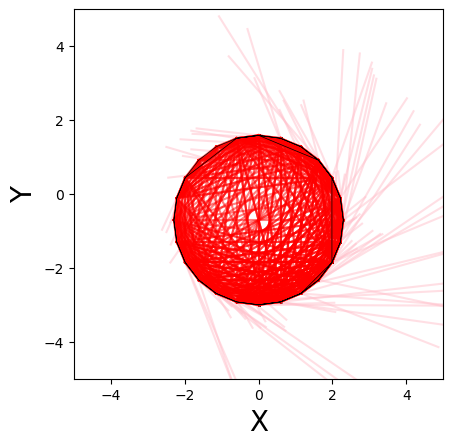

 -0.0019900448191885996 0.010000000000000002]
[0.016062838329889438 -0.0038486798912870067 0.0006215421876077222; -0.003848679891287006 0.023184426654795958 0.0008100095491816075; 0.0006215421876077222 0.0008100095491816075 0.010000000000000002]
[0.00892735376263278 -0.0004977693300638004 -7.816574690802484e-5; -0.0004977693300637995 0.030319911222052614 -0.00018870880629837463; -7.816574690802484e-5 -0.00018870880629837463 0.010000000000000002]
[0.01606283832988927 -0.003848679891287045 0.0036491018981949282; -0.003848679891287044 0.02318442665479612 -0.002800054368370206; 0.0036491018981949282 -0.002800054368370206 0.010000000000000002]
[0.021875999155973536 0.0024622502648607835 0.0025437778739347675; 0.0024622502648607844 0.01737126582871186 -0.0033151158681838273; 0.0025437778739347675 -0.0033151158681838273 0.010000000000000002]
[0.013418190847544401 0.015475001543455429 0.0003302900841253972; 0.015475001543455429 0.025829074137140993 -0.0025088022648878973; 0.0003302900841253972

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb06284bca0>

In [16]:
hat_xs, zlist = read_data()
edges = make_edges(hat_xs, zlist)
draw(hat_xs, zlist, edges)